# DEADLINE - 11.11.2024 

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

N = scipy.stats.norm.cdf
n = scipy.stats.norm.pdf
sns.set_style("darkgrid")

np.random.seed(1)

## Task 2.1
Compare the convergence of approximate and exact CRR and JR binomial trees to the Black-Scholes price for different parameter sets.

In [5]:
class BinomialTree():

    def __init__(self,S0,K,r,sigma,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.CRR_u_approx = np.exp(sigma*np.sqrt(self.delta_t))
        self.CRR_d_approx = 1/self.CRR_u_approx
        self.CRR_u = (np.exp(-r*self.delta_t) + np.exp((r + sigma**2)*self.delta_t) + np.sqrt((np.exp(-r*self.delta_t) + np.exp((r+ sigma**2)*self.delta_t))**2-4))/2
        self.CRR_d = 1/self.CRR_u
        self.JR_u = np.exp(r*self.delta_t)*(1 + np.sqrt(np.exp(self.delta_t*sigma**2) - 1))
        self.JR_d = np.exp(r*self.delta_t)*(1 - np.sqrt(np.exp(self.delta_t*sigma**2) - 1))
        self.JR_u_approx = np.exp((r - sigma**2/2)*self.delta_t + sigma*np.sqrt(self.delta_t))
        self.JR_d_approx = np.exp((r - sigma**2/2)*self.delta_t - sigma*np.sqrt(self.delta_t))

    def european_price_option(self, option_type, method = 'CRR_approx'):
        if method == 'CRR_approx':
            u = self.CRR_u_approx
            d = self.CRR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'CRR':
            u = self.CRR_u
            d = self.CRR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR':
            u = self.JR_u
            d = self.JR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR_approx':
            u = self.JR_u_approx
            d= self.JR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)

        stock_tree = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (u ** (i - j)) * (d ** j)
        
        # Step 2: Initialize option price tree at maturity
        option_tree = np.zeros((self.N + 1, self.N + 1))
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, stock_tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - stock_tree[:, self.N])

        # Step 3: Backward induction for option price at each node
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                option_tree[j, i] = np.exp(-self.r * self.delta_t) * (q * option_tree[j, i + 1] + (1 - q) * option_tree[j + 1, i + 1])

        return option_tree[0, 0]
    
    def american_price_option(self, option_type, method = 'CRR_approx'):
        if method == 'CRR_approx':
            u = self.CRR_u_approx
            d = self.CRR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'CRR':
            u = self.CRR_u
            d = self.CRR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR':
            u = self.JR_u
            d = self.JR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR_approx':
            u = self.JR_u_approx
            d= self.JR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)

        stock_tree = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (u ** (i - j)) * (d ** j)
        
        # Step 2: Initialize option price tree at maturity
        option_tree = np.zeros((self.N + 1, self.N + 1))
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, stock_tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - stock_tree[:, self.N])

        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                # Calculate the value of holding the option
                hold_value = np.exp(-self.r * self.delta_t) * (q * option_tree[j, i + 1] + (1 - q) * option_tree[j + 1, i + 1])

                # Calculate the intrinsic value of exercising the option immediately
                if option_type == 'call':
                    exercise_value = max(0, stock_tree[j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[j, i])

                # Take the maximum of holding and exercising
                option_tree[j, i] = max(hold_value, exercise_value)

        return option_tree[0, 0]


def binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR_approx'):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.european_price_option(option_type, method)
    return call_price_N

def american_binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR_approx'):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.american_price_option(option_type, method)
    return call_price_N


In [6]:
def call_price(S, K, T, r, sigma):
    N = ss.norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def put_price(S, K, T, r, sigma):
    N = ss.norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

In [ ]:
#for ploting
def plot_binomial_european(S0,K,r,sigma,T,Nmax, option_type):
    prices_CRR_approx = binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type , method = 'CRR_approx')
    prices_CRR = binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR')
    prices_JR_approx = binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'JR_approx')
    prices_JR = binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'JR')

    if option_type =='call':
        BS = call_price(S0, K, T, r, sigma)
    elif option_type =='put':
        BS = put_price(S0, K, T, r, sigma)

    plt.figure(figsize=(12, 8))
    plt.plot(prices_CRR_approx, 'o-',color = 'royalblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR approx')
    plt.plot(prices_CRR, 'o-',color = 'skyblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR exact')
    plt.plot(prices_JR_approx ,'o-',color = 'magenta' ,markersize = 1.5,linewidth = 0.8,  label = 'JR approx')
    plt.plot(prices_JR , 'o-',color ='limegreen', markersize = 1.5,linewidth = 0.8, label = 'JR exact')
    plt.axhline(BS, label = 'BS',color= 'red',linewidth = 0.8)

    plt.xlabel("Number of Steps (N)")
    plt.ylabel("Option Price")
    plt.title(f"European {option_type} option ($S_0$={S0},K={K},r={r},$\sigma$={sigma},T={T})")
    plt.legend()
    plt.show()

def plot_binomial_american(S0,K,r,sigma,T,Nmax, option_type):
    prices_CRR_approx = american_binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type , method = 'CRR_approx')
    prices_CRR = american_binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR')
    prices_JR_approx = american_binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'JR_approx')
    prices_JR = american_binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'JR')

    plt.figure(figsize=(12, 8))
    plt.plot(prices_CRR_approx, 'o-',color = 'royalblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR approx')
    plt.plot(prices_CRR, 'o-',color = 'skyblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR exact')
    plt.plot(prices_JR_approx ,'o-',color = 'magenta' ,markersize = 1.5,linewidth = 0.8,  label = 'JR approx')
    plt.plot(prices_JR , 'o-',color ='limegreen', markersize = 1.5,linewidth = 0.8, label = 'JR exact')

    plt.xlabel("Number of Steps (N)")
    plt.ylabel("Option Price")
    plt.title(f"American {option_type} option ($S_0$={S0},K={K},r={r},$\sigma$={sigma},T={T})")
    plt.legend()
    plt.show()
  

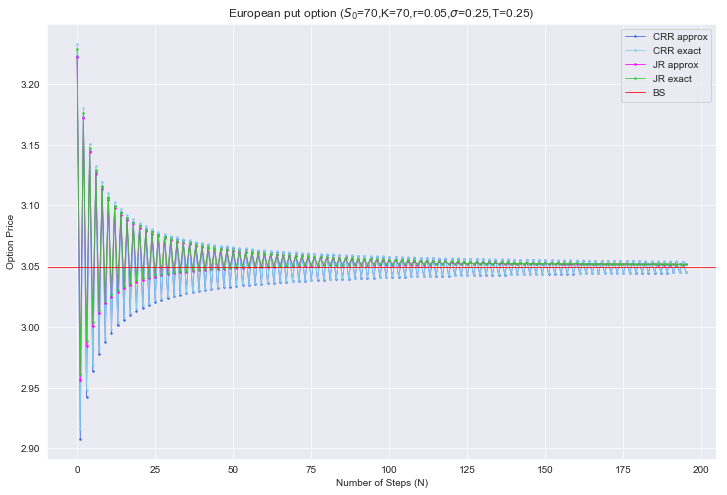

In [22]:
plot_binomial_european(S0=70,K=70,r=0.05,sigma=0.25,T=0.25,Nmax=200, option_type='put')

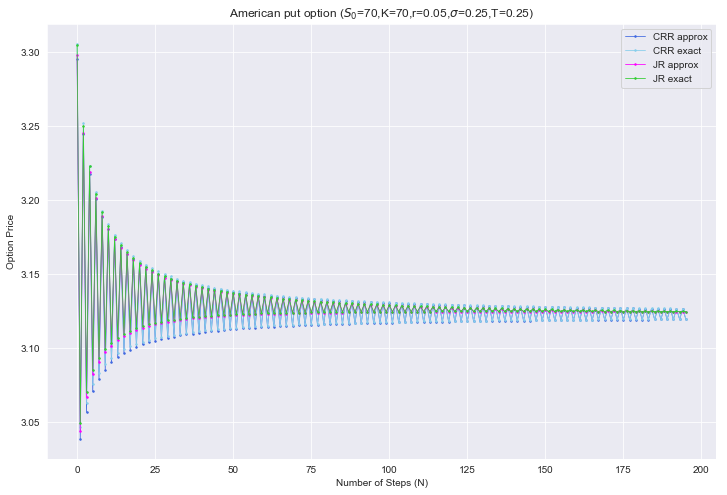

In [23]:
plot_binomial_american(S0 = 70,K = 70, T = 0.25, r = 0.05, sigma = 0.25, Nmax = 200, option_type='put')

We can see that prices are oscilating and converging to the price calculated from Black-Scholes formula. 
The fastest converges the JR exact method. For american option the price is slightly higher.

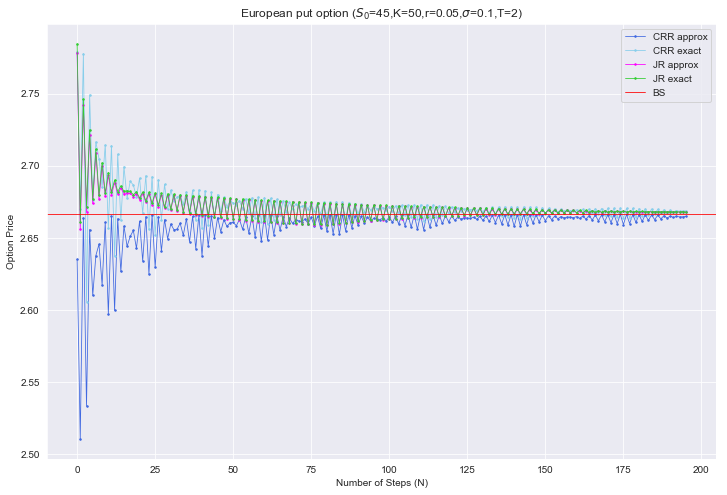

In [24]:
plot_binomial_european(S0=45,K=50,r=0.05,sigma=0.1,T=2,Nmax=200, option_type='put')

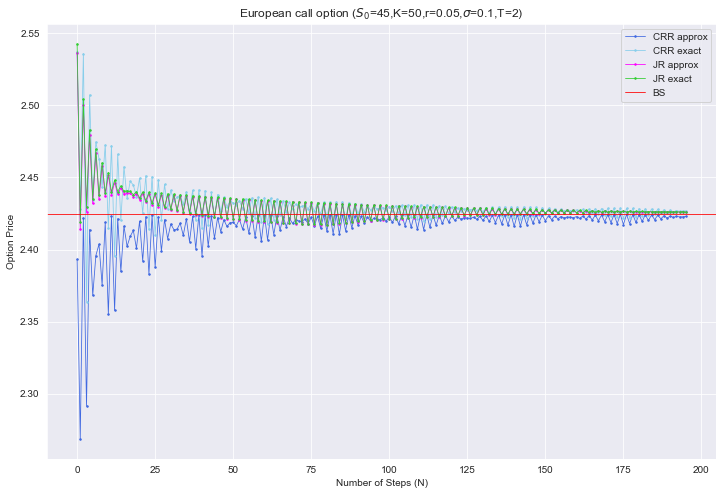

In [25]:
plot_binomial_european(S0=45,K=50,r=0.05,sigma=0.1,T=2,Nmax=200, option_type='call')

The two above plots are for the same arguments but different type of option. They are strikingly similar in their shape of convergence apart from the price which is higher for put option because of the chosen parameters.


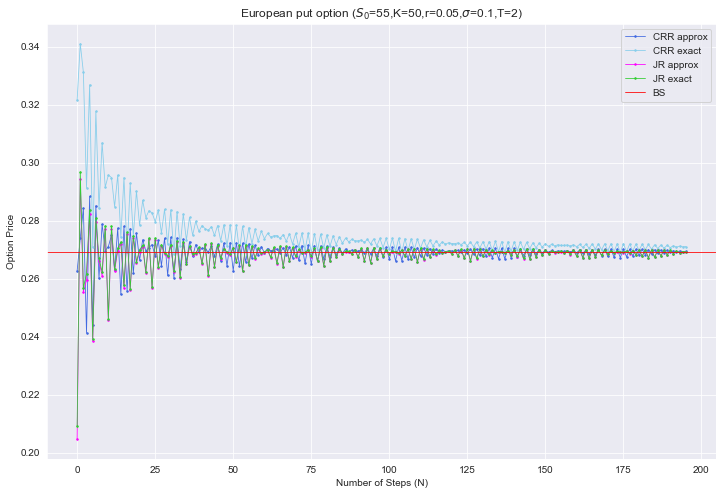

In [26]:
plot_binomial_european(S0=55,K=50,r=0.05,sigma=0.1,T=2,Nmax=200, option_type='put')

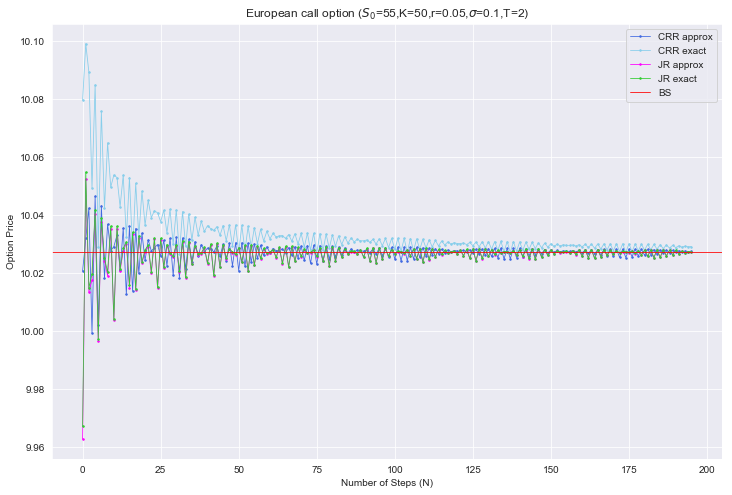

In [27]:
plot_binomial_european(S0=55,K=50,r=0.05,sigma=0.1,T=2,Nmax=200, option_type='call')

Here, we have the opposite situation where current price is higher than strike prize giving us the higher price for call option. The same as before, the shape of the two plots are almast the same.

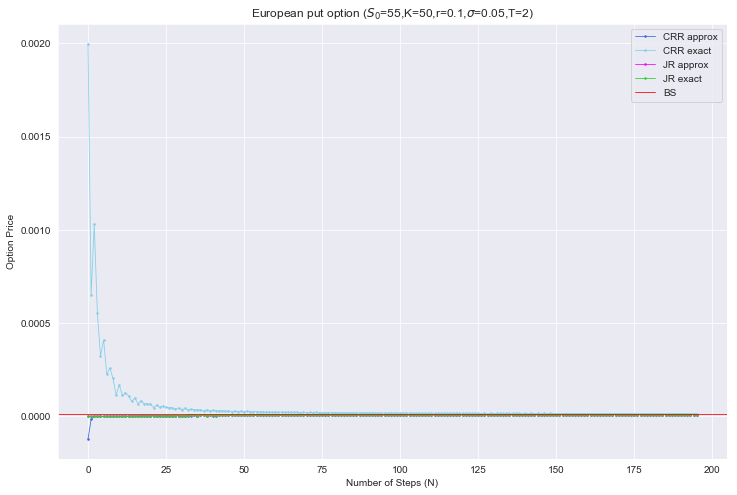

In [28]:
plot_binomial_european(S0=55,K=50,r=0.1,sigma=0.05,T=2,Nmax=200, option_type='put')

For this case where we increase the interest rate we can observe that price calculating with CRR exact method is starting with higher value than in other methods and converges to the BS price fast.

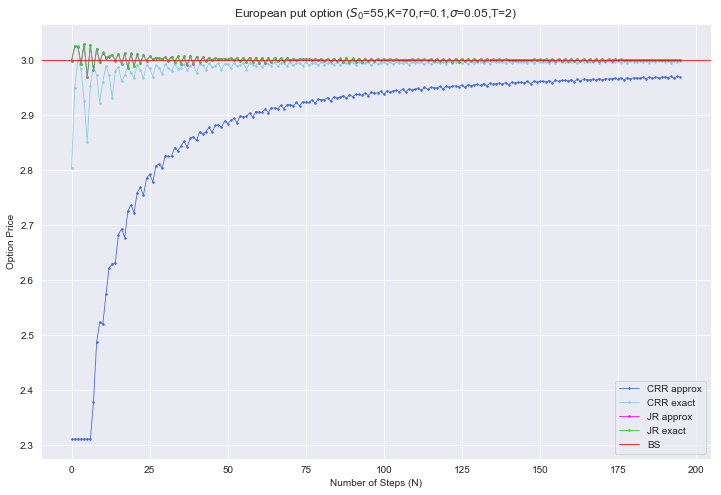

In [29]:
plot_binomial_european(S0=55,K=70,r=0.1,sigma=0.05,T=2,Nmax=200, option_type='put')

In this case, having higer interest rate (the same as the example before) and higher strike price than the current price, we can observe that the price received from the CRR approxiamation is at the begining lower than  in the other method and converges into the BS price, however needs more steps to converge closer.

## Task 2.2
Compare the convergence of Boyle and Kamrad-Ritchken trinomial trees to the Black-Scholes price for different parameter sets. Compare with the results for Task 2.1

In [ ]:
class BoyleTrinomialTree():
    def __init__(self,S0,K,r,sigma,lam,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.lam = lam #stretch parameter
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.u = np.exp(lam*sigma*np.sqrt(self.delta_t))
        self.d = 1/self.u
        self.m = 1
        self.q_u = ((np.exp((2*r + sigma**2)*self.delta_t) - np.exp(r*self.delta_t))*self.u - (np.exp(r*self.delta_t) - 1))/((self.u-1)*(self.u**2-1))
        self.q_d = ((np.exp((2*r + sigma**2)*self.delta_t) - np.exp(r*self.delta_t))*self.u**2 - (np.exp(r*self.delta_t) - 1)*self.u**3)/((self.u-1)*(self.u**2-1))
        self.q_m = 1 - self.q_u - self.q_d

    def european_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                #not konow why does it work
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])

        # Step 3: Backward induction 
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                option_tree[self.N + j, i] = (np.exp(-self.r * self.delta_t) * 
                                              (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                               self.q_m * option_tree[self.N + j, i + 1] +
                                               self.q_d * option_tree[self.N + j - 1, i + 1]))
        # print(option_tree)

        return option_tree[self.N, 0]
    
    def american_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])


        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                hold_value = (np.exp(-self.r * self.delta_t) * 
                                    (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                     self.q_m * option_tree[self.N + j, i + 1] +
                                     self.q_d * option_tree[self.N + j - 1, i + 1]))

                if option_type == 'call':
                    exercise_value = max(0, stock_tree[self.N + j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[self.N + j, i])


                option_tree[self.N + j, i] = max(hold_value, exercise_value)

        return option_tree[self.N, 0]


class KRTrinomialTree():
    def __init__(self,S0,K,r,sigma,lam,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.lam = lam #stretch parameter
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.u = np.exp(lam*sigma*np.sqrt(self.delta_t))
        self.d = 1/self.u
        self.m = 1
        self.q_u = 1/(2*lam**2) + ((r- 0.5*sigma**2)*np.sqrt(self.delta_t))/(2*lam*sigma)
        self.q_d = 1/(2*lam**2) - ((r- 0.5*sigma**2)*np.sqrt(self.delta_t))/(2*lam*sigma)
        self.q_m = 1 - 1/(lam**2)

    def european_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                #not konow why does it work
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])

        # Step 3: Backward induction 
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                option_tree[self.N + j, i] = (np.exp(-self.r * self.delta_t) * 
                                              (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                               self.q_m * option_tree[self.N + j, i + 1] +
                                               self.q_d * option_tree[self.N + j - 1, i + 1]))
        # print(option_tree)

        return option_tree[self.N, 0]
    
    def american_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])


        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                hold_value = (np.exp(-self.r * self.delta_t) * 
                                    (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                     self.q_m * option_tree[self.N + j, i + 1] +
                                     self.q_d * option_tree[self.N + j - 1, i + 1]))

                if option_type == 'call':
                    exercise_value = max(0, stock_tree[self.N + j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[self.N + j, i])


                option_tree[self.N + j, i] = max(hold_value, exercise_value)

        return option_tree[self.N, 0]   



def trinomial_pricing(S0,K,r,sigma,lam,T,Nmax, option_type, method = 'Boyle'):
    ranging = range(5,Nmax +1,1)
    price_N = np.zeros(len(ranging))

    if method == 'Boyle':
        for i, N in enumerate(ranging):
            trinomTree = BoyleTrinomialTree(S0,K,r,sigma,lam,T,N)
            price_N[i] = trinomTree.european_price_option(option_type)
        return price_N
    elif method == 'KR':
        for i, N in enumerate(ranging):
            trinomTree = KRTrinomialTree(S0,K,r,sigma,lam,T,N)
            price_N[i] = trinomTree.european_price_option(option_type)
        return price_N


def american_trinomial_pricing(S0,K,r,sigma,lam,T,Nmax, option_type, method = 'Boyle'):
    ranging = range(5,Nmax +1,1)
    price_N = np.zeros(len(ranging))

    if method == 'Boyle':
        for i, N in enumerate(ranging):
            trinomTree = BoyleTrinomialTree(S0,K,r,sigma,lam,T,N)
            price_N[i] = trinomTree.american_price_option(option_type)
        return price_N
    elif method == 'KR':
        for i, N in enumerate(ranging):
            trinomTree = KRTrinomialTree(S0,K,r,sigma,lam,T,N)
            price_N[i] = trinomTree.american_price_option(option_type)
        return price_N


In [10]:
def plot_trinomial_european(S0,K,r,sigma,lam,T,Nmax, option_type):
    boyle = trinomial_pricing(S0,K,r,sigma,lam,T,Nmax, option_type , method = 'Boyle')
    kr = trinomial_pricing(S0,K,r,sigma,lam,T,Nmax, option_type, method = 'KR')

    if option_type =='call':
        BS = call_price(S0, K, T, r, sigma)
    elif option_type =='put':
        BS = put_price(S0, K, T, r, sigma)

    plt.figure(figsize=(12, 8))
    plt.plot(boyle, 'o-',color = 'royalblue',markersize = 1.5,linewidth = 0.8,  label = 'Boyle')
    plt.plot(kr, 'o-',color = 'skyblue',markersize = 1.5,linewidth = 0.8,  label = 'KR')
    plt.axhline(BS, label = 'BS',color= 'red',linewidth = 0.8)

    plt.xlabel("Number of Steps (N)")
    plt.ylabel("Option Price")
    plt.title(f"European {option_type} option ($S_0$={S0},K={K},r={r},$\sigma$={sigma},$\lambda$={np.round(lam,3)},T={T})")
    plt.legend()
    figure = plt.gcf()
    # plt.show()
    return figure, figure.gca()

def plot_trinomial_american(S0,K,r,sigma,lam,T,Nmax, option_type):
    boyle = american_trinomial_pricing(S0,K,r,sigma,lam,T,Nmax, option_type , method = 'Boyle')
    kr = american_trinomial_pricing(S0,K,r,sigma,lam,T,Nmax, option_type, method = 'KR')

    plt.figure(figsize=(12, 8))
    plt.plot(boyle, 'o-',color = 'royalblue',markersize = 1.5,linewidth = 0.8,  label = 'Boyle')
    plt.plot(kr, 'o-',color = 'skyblue',markersize = 1.5,linewidth = 0.8,  label = 'KR')

    plt.xlabel("Number of Steps (N)")
    plt.ylabel("Option Price")
    plt.title(f"American {option_type} option ($S_0$={S0},K={K},r={r},$\sigma$={sigma},$\lambda$={np.round(lam,3)},T={T})")
    plt.legend()
    figure = plt.gcf()
    # plt.show()
    return figure, figure.gca()

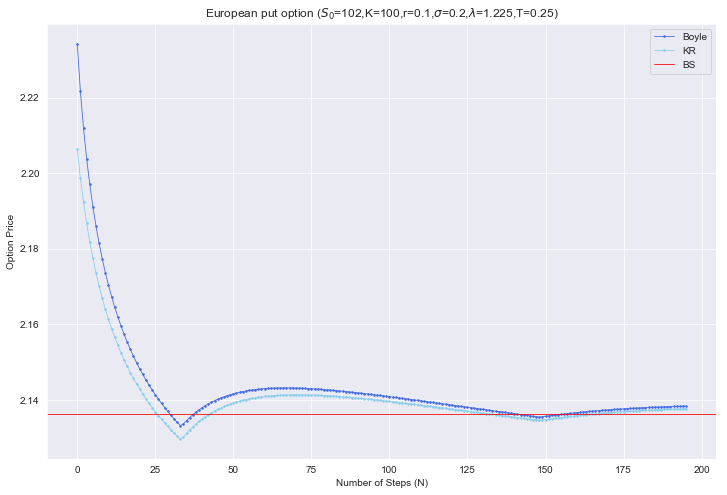

In [31]:
fig_tri, ax_tri = plot_trinomial_european(S0=102,K=100,r=0.1,sigma=0.2,lam=1.225,T=0.25,Nmax=200,option_type='put')

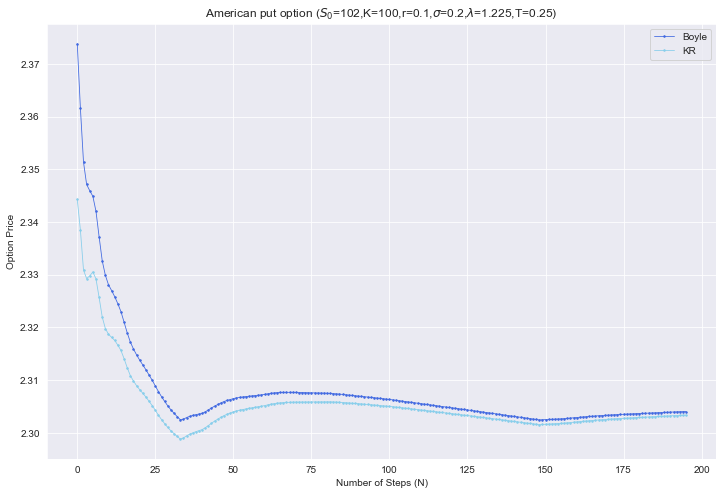

In [30]:
fig_tri2, ax_tri2 = plot_trinomial_american(S0=102,K=100,r=0.1,sigma=0.2,lam=1.225,T=0.25,Nmax=200,option_type='put')

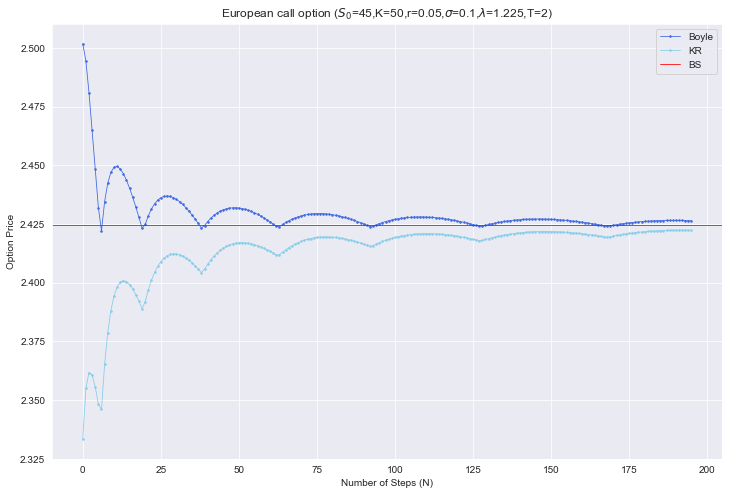

In [11]:
fig_tri3, ax_tri3 = plot_trinomial_european(S0=45,K=50,r=0.05,sigma=0.1,lam=np.sqrt(3/2),T=2,Nmax=200,option_type='call')

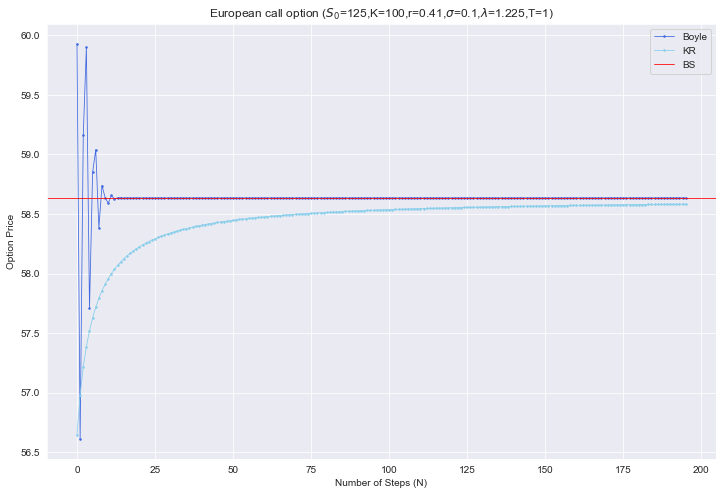

In [39]:
fig_tri4, ax_tri4 =plot_trinomial_european(S0=125,K=100,r=0.41,sigma=0.1,lam=np.sqrt(3/2),T=1,Nmax=200,option_type='call')